In [3]:
import numpy as np
import sympy as sp
import math
from sympy import ntheory
from sympy.ntheory import continued_fraction_periodic
import matplotlib.pyplot as plt
from matplotlib.patches import Arc

In [13]:
def classRepresentatives(length):
    trace = 2*np.cosh(length/2)
    bound = math.floor(trace**2-4)
    quadraticForms = []
    for D in range(2,bound+1):
        if isASquare(D):
            continue
        elif D%4 == 0:
            quadraticForms+=representatives(D)
        elif D%4 == 1:
            quadraticForms+=representatives(D)
    return quadraticForms

def representatives(D):
    reps = []
    seenFracs = []
    for i in range(1,math.floor(np.sqrt(D))+1):
        B = -i
        if not (B**2-D)%4==0:
            continue
        for j in range(math.ceil((np.sqrt(D)+B)/2),math.floor((np.sqrt(D)-B)/2)+1):
            A = j
            if not ((B**2-D)//4)%A==0:
                continue
            C = ((B**2-D)//4)//A
            Q = [A,B,C]
            frac = ntheory.continued_fraction_periodic(-Q[1], 2*Q[0], disc(Q))[0]
            if frac not in seenFracs:
                seenFracs+=permutationsOf(frac)
                reps.append(Q)
            else:
                continue
    return reps

def permutationsOf(a):
    perms = []
    if len(a)%2==0:
        for n in range(0,len(a),2):
            perms.append(a[n:]+a[:n])
    else:
        for n in range(0,len(a)):
            perms.append(a[n:]+a[:n])
    return perms

def disc(quad):
    return quad[1]**2-4*quad[0]*quad[2]

def areEquivalent(Q,W):
    return ntheory.continued_fraction_periodic(-Q[1], 2*Q[0], disc(Q))[0] in permutationsOf(ntheory.continued_fraction_periodic(-W[1], 2*W[0], disc(W))[0])

def isASquare(n):
    for i in range(2,n):
        if n==i**2:
            return True
    return False

def quadToMat(Q):
    mat = np.identity(2)
    length = 0
    for x in ntheory.continued_fraction_periodic(-Q[1], 2*Q[0],disc(Q))[0]:
        mat = np.matmul(mat,[[x,1],[1,0]])
        length += 1
    if length % 2 == 1:
        mat = np.matmul(mat,mat)
    return np.array(mat).astype(np.float64)

In [14]:
def geodesicInfoFromMatrix(M): #input is a hyperbolic matrix M which lies in SL_2(Z)
    tr = np.trace(M)
    if np.abs(tr) <= 2:
        raise ValueError('Matrix should have trace > 2')
    if tr < 0:
        M = -M
        tr = -tr
    length = 2*np.log(tr/2+np.sqrt((tr/2)**2-1))
    eig = np.exp(1)**(length/2)
    a = M.item(0,0)
    b = M.item(0,1)
    c = M.item(1,0)
    d = M.item(1,1)
    if c > 0:
        eigMat = (1/((c**2)*(tr**2-4))**(1/4))*np.matrix([[eig-d,1/eig-d],[c,c]])
    else: 
        eigMat = (1/((c**2)*(tr**2-4))**(1/4))*np.matrix([[-eig+d,1/eig-d],[-c,c]])
    visPt = (eig-d)/c
    newA = eigMat.item(0,0)
    newB = eigMat.item(0,1)
    newC = eigMat.item(1,0)
    newD = eigMat.item(1,1)
    z = (newA*1j+newB)/(newC*1j+newD)
    zeta = 1j/(newC*1j+newD)**2
    return (length,eig,eigMat,visPt,z,zeta)

def inFundDom(z):
    return (np.abs(z) >= 1) and (np.abs(np.real(z))<=1/2)

def fundDomRep(z,zeta):
    mat = np.matrix([[1,0],[0,1]])
    while not inFundDom(z):
        trans = np.floor(np.real(z)+1/2) #translation factor
        z = z - trans #desired z
        mat = np.matmul(np.matrix([[1,-trans],[0,1]]),mat)
        if (np.abs(z) < 1):
            zeta = zeta/z**2
            z = -1/z
            mat = np.matmul(np.matrix([[0,1],[-1,0]]),mat)
    return (z,zeta,mat)

def fundDomGeo(mat,res): #input hyperbolic geodesic matrix in SL_2(Z)
    geoInfo = geodesicInfoFromMatrix(mat)
    length = geoInfo[0]
    eigMat = geoInfo[2]
    z = geoInfo[4]
    zeta = geoInfo[5]
    pointlist = []
    newRep = fundDomRep(z,zeta)
    z = newRep[0]
    zeta = newRep[1]
    eigMat = np.matmul(newRep[2],eigMat)
    pointlist.append((np.real(z),np.imag(z)))
    yMax = np.imag(z)
    for t in range(res):
        e = np.exp(1)
        eigMat = np.matmul(eigMat,np.matrix([[e**(length/(2*res)),0],[0,e**(-length/(2*res))]]))
        newA = eigMat.item(0,0)
        newB = eigMat.item(0,1)
        newC = eigMat.item(1,0)
        newD = eigMat.item(1,1)
        z = (newA*1j+newB)/(newC*1j+newD)
        if np.imag(z) > yMax:
            yMax = np.imag(z)
        zeta = 1j/(newC*1j+newD)**2
        if not inFundDom(z):
            newRep = fundDomRep(z,zeta)
            z = newRep[0]
            zeta = newRep[1]
            eigMat = np.matmul(newRep[2],eigMat)
        pointlist.append((np.real(z),np.imag(z)))
    fig, ax = plt.subplots()
    # plt.ylim(0,yMax+0.2) # can change the bounds on the y-axis
    ax.scatter(*zip(*pointlist),s=0.1)
    ax.vlines([-1/2,1/2],np.sin(np.pi/3),yMax)
    ax.add_patch(Arc((0, 0), 2, 2,
                 theta1=60, theta2=120))
    plt.show()

In [15]:
classRepresentatives(3)

[[1, -1, -1], [1, -2, -1], [1, -2, -2], [2, -2, -1], [1, -3, -1], [2, -1, -2]]

[1, -1, -1]


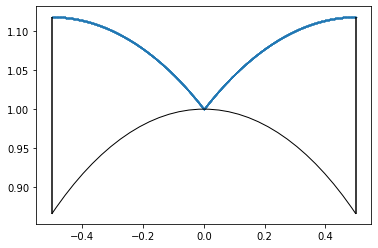

[1, -2, -1]


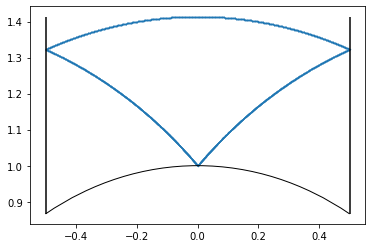

[1, -2, -2]


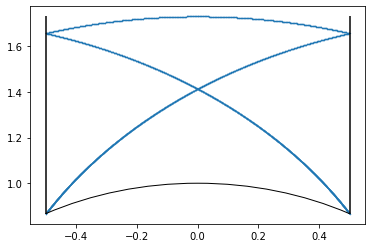

[2, -2, -1]


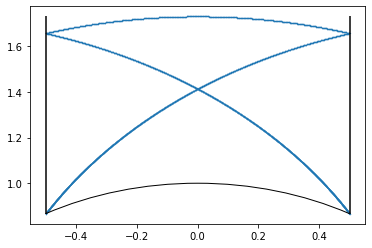

[1, -3, -1]


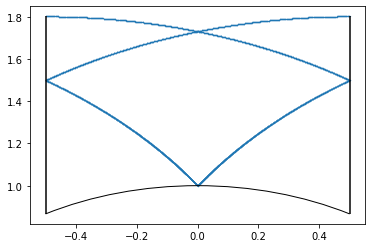

[2, -1, -2]


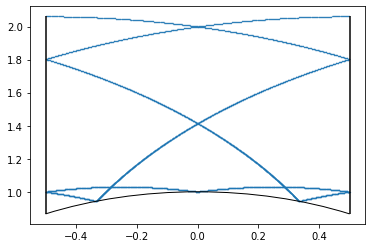

In [19]:
for Q in classRepresentatives(3):
    print(Q)
    fundDomGeo(quadToMat(Q),5000)